In [56]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse

from collections import Counter


from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Import Dataset

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

Binarize the Data

In [5]:
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

# 2 Un-Collapsed Gibbs Sampling

## 2.1 Algorithm

Joint Posterior 

$$\begin{align}
    p(\mathbf{\pi},\mathbf{\theta},\mathbf{z}|\mathbf{X},\mathbf{\alpha},a,b) \propto p(\mathbf{X}|\mathbf{z},\mathbf{\theta}) p(\mathbf{z}|\mathbf{\pi}) p(\mathbf{\pi}|\mathbf{\alpha}) p(\mathbf{\theta}|a,b)
\end{align}$$

Routine

1) Initialize 
$$\begin{align}
    \boldsymbol{\alpha} &= [\alpha_1 = \frac{1}{K},...,\alpha_K = \frac{1}{K}]\\
    a,b &= \frac{1}{2}\\
    \boldsymbol{\pi} &\sim \mathcal{Dirichlet}(\boldsymbol{\alpha})\\
    \boldsymbol{\theta} &\sim \mathcal{Beta}(a,b)\\
    \boldsymbol{z} &\sim \mathcal{Cat}(\boldsymbol{\pi})
\end{align}$$




2) For $t=1,..,N$
$$\begin{align}
    \text{Sample } \boldsymbol{\pi}^{(t)} &\sim \mathrm{Dirichlet}(\boldsymbol{\alpha}_N) \\
        \boldsymbol{\alpha}_N &= \left[\alpha_0^1 + n_1,\, \alpha_0^2 + n_2,\, \dots,\, \alpha_0^K + n_K \right],
        \quad \text{where} \quad
        n_k = \sum_{i=1}^N \mathbb{1}(z_i^{(t-1)} = k) \\\\

    \text{Sample } \boldsymbol{\theta}^{(t)} &\sim \mathrm{Beta}(\mathbf{a}_N, \mathbf{b}_N) \\
        \mathbf{a}_N &= \left[
        \begin{matrix}
        a_{0,1} + n_{1,1}^{(1)} & \cdots & a_{0,D} + n_{1,D}^{(1)} \\
        \vdots & \ddots & \vdots \\
        a_{K,1} + n_{K,1}^{(1)} & \cdots & a_{K,D} + n_{K,D}^{(1)}
        \end{matrix}
        \right],
        \quad \text{where} \quad
        n_{k,d}^{(1)} = \sum_{i=1}^N \mathbb{1}(x_{i,d} = 1 \land z_i^{(t-1)} = k) \\\\

        \mathbf{b}_N &= \left[
        \begin{matrix}
        b_{0,1} + n_{1,1}^{(0)} & \cdots & b_{0,D} + n_{1,D}^{(0)} \\
        \vdots & \ddots & \vdots \\
        b_{K,1} + n_{K,1}^{(0)} & \cdots & b_{K,D} + n_{K,D}^{(0)}
        \end{matrix}
        \right],
        \quad \text{where} \quad
        n_{k,d}^{(0)} = \sum_{i=1}^N \mathbb{1}(x_{i,d} = 0 \land z_i^{(t-1)} = k)\\\\

    \text{Sample } \mathbf{z}^{(t)} &= [z_1^{(t)}, \dots, z_N^{(t)}] \quad \text{where,}\\

        &\boldsymbol{z}_i^{(t)} \sim \text{Categorical}(p_1^{(i)},...,p_K^{(i)}) \quad \text{where,}\\
        &\qquad p_k^{(i)} \propto \pi_k^{(t)} \prod_{d=1}^D (\theta_{k,d}^{(t)})^{x_{i,d}}(1-\theta_{k,d}^{(t)})^{(1 - x_{i,d})}
\end{align}$$

---

Softmax:

$$
    \mathbf{softmax}_i(p_k) = \frac{\exp(p_{ik}) - \exp(\mathbf{max}(\mathbf{p}_i))}{\sum_{k'}\exp(p_{ik'})}
$$

In [7]:
def sampleZs(X, θ, π, eps):
    ''' 
        Compute softmax to produce cat distribution for each row

        @param (X) : data matrix (n x d)
        @param (θ) : biases for each pixel (K x d)
        @param (π) : mixture weights for each component (K)
    '''

    # Compute Categorical Distribution over components for each row using SoftMax
    logp  = np.log(π + eps) + (X @ np.log(θ + eps).T + (1 - X) @ np.log(1 - θ + eps).T) # log likelihood
    logp -= logp.max(axis=1, keepdims=True) # reduce logits for numerical stability (invariance property)
    p     = np.exp(logp)
    p    /= p.sum(axis=1, keepdims=True) # normalize

    # Inverse Sample from Categorical Distribution
    cdf = np.cumsum(p, axis=1) # compute CDF for each row (each categorical distribution)
    u   = rng.random(size=(p.shape[0], 1))
    return (cdf > u).argmax(axis=1)  # return first index where cdf is greater than random u

In [8]:
def sample_θ(X, zs, a_mat, b_mat, K) :
    ''' 
        Samples θs from multivariate Beta distribution

        @param (X)     : data matrix (nxd)
        @param (zs)    : component assignments (n)
        @param (a_mat) : multi-var beta prior for a (K, d)
        @param (b_mat) : multi-var beta prior for b (K, d)
        @param (K)     : the number of components
    '''

    n,d=X.shape

    nkd1 = np.zeros((K,d))
    nkd0 = np.zeros((K,d))

    for k in range(K):
        indices = np.where(zs == k)[0].tolist()
        nkd1[k] = X[indices].sum(axis=0)
        nkd0[k] = len(indices) - nkd1[k]
    
    return rng.beta(a_mat + nkd1, b_mat + nkd0)

In [9]:
def sample_π(zs, α_0, K):
    ''' 
        Samples mixing weights from Dirichlet distribution parameterized by pseudocounts of components
        
        @param (zs)  : cluster assignments (n)
        @param (α_0) : Dirichlet prior list (K)
        @param (K)   : the number of components
    '''

    z_counts = np.bincount(zs, minlength=K)
    return rng.dirichlet(α_0 + z_counts)

In [10]:
def gibbs(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape
    X = X.astype(np.uint8)

    πs = np.zeros((num_iter + num_burn, K))
    zs = np.zeros((num_iter + num_burn, n), dtype=np.int16)
    θs = np.zeros((num_iter + num_burn, K, d))

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    πs[0] = rng.dirichlet(α_0)
    R = rng.random((K,d))
    θs[0] = R/np.sum(R, axis=1, keepdims=True)
    zs[0] = sampleZs(X, θs[0], πs[0], eps)

    for t in range(1,num_iter+num_burn):
        πs[t] = sample_π(zs[t-1], α_0, 10)

        θs[t] = sample_θ(X, zs[t-1], a_mat, b_mat, 10)
        
        zs[t] = sampleZs(X, θs[t],πs[t],eps).astype(np.int16)
    
    return πs[num_burn:], θs[num_burn:], zs[num_burn:]

# 2.2 Evaluation

In [11]:
πs,θs,zs= gibbs(X_mnist_train, 1000, 250, 10)

In [12]:
metrics.adjusted_rand_score(Y_mnist_train, zs[-1])

0.3948179243242432

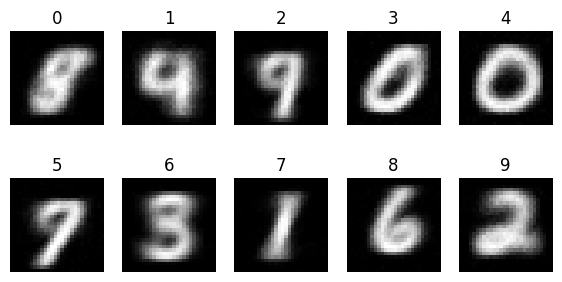

In [13]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = θs[-1][k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

# 3 Collapsed Gibbs Sampling

Full Posterior:
$$
    P(\boldsymbol{\pi},\boldsymbol{\theta},\mathbf{z}|\mathbf{X},\mathbf{a},\mathbf{b},\boldsymbol{\alpha})\propto \underbrace{p(\mathbf{X}|\mathbf{z},\mathbf{\theta}) p(\mathbf{\theta}|a,b)}_{\text{Conjugacy}} \underbrace{p(\mathbf{z}|\mathbf{\pi}) p(\mathbf{\pi}|\mathbf{\alpha})}_{\text{Conjugacy}}
$$

$$
    \prod_k^{K}\prod_d^{D} \frac{1}{B(a_{k,d}, b_{k,d})} \theta_{k,d}^{(a_{k,d} + n^{(1)}_{k,d} - 1)}(1-\theta_{k,d})^{(b_{k,d} + n^{(0)}_{k,d} - 1)}\\
    =\frac{1}{B(\boldsymbol{a}, \boldsymbol{b})} \boldsymbol{\theta}^{(\boldsymbol{a} + \boldsymbol{n^{(1)}}- 1)}(1-\boldsymbol{\theta})^{(\boldsymbol{b} + \boldsymbol{n^{(0)}} - 1)}
$$

---

## Beta-Binomial Conjugacy:
$$\begin{align}
    \underset{Binomial}{P(\mathbf{X}|\mathbf{z},\boldsymbol{\theta})}&\underset{Beta}{P(\boldsymbol{\theta}|\mathbf{a},\mathbf{b})} &= 
        \left[ \prod_{i}^{N} \prod_{d}^{D} \theta_{d,z_i}^{x_{d,i}} (1 - \theta_{d,z_i})^{(1 - x_{d,i})} \right]\left[ \prod_{k}^{K} \prod_{d}^{D} \frac{\theta_{d,k}^{(a_{d,k}-1)}(1-\theta_{d,k})^{(b_{d,k} - 1)}}{B(a_{d,k},b_{d,k})} \right]
\end{align}$$

$\quad$ Let $n_{d,k}^{(1)} = \sum_{i}^{N} \mathbb{1}(z_i = k, x_{d,i} = 1)$,  hence $\quad \prod_{i}^{N} \theta_{d,z_i}^{x_{d,i}} = \prod_{k}^{K} \theta_{d,k}^{n_{d,k}^{(1)}}$

$$\begin{align}
     &= \left[ \prod_{k}^{K} \prod_{d}^{D} \theta_{d,k}^{n_{d,k}^{(1)}} (1 - \theta_{d,k})^{n_{d,k}^{(0)}} \right] \left[ \prod_{k}^{K} \prod_{d}^{D} \frac{\theta_{d,k}^{(a_{d,k}-1)}   (1-\theta_{d,k})^{(b_{d,k} - 1)}}{B(a_{d,k},b_{d,k})} \right]\\

    &= \prod_{k}^{K} \prod_{d}^{D} \left(\frac{1}{B(a_{d,k},b_{d,k})} \right) \theta_{d,k}^{(a_{d,k}+n_{d,k}^{(1)}-1)} (1-\theta_{d,k})^{(b_{d,k} + n_{d,k}^{(0)}-1)}
\end{align}$$

$\quad$ Let $\mathbf{a},\mathbf{b},\boldsymbol{\theta},\mathbf{n^{(0)}},\mathbf{n^{(1)}}$ be $(k \times d)$ matrices. E.g.  $B(\mathbf{a},\mathbf{b})=\prod_k^{K}\prod_{d}^{D} B(a_{d,k},b_{d,k})$

$$\begin{align}
    &= \frac{1}{B(\mathbf{a},\mathbf{b})}\boldsymbol{\theta}^{(\mathbf{a} + \mathbf{n}^{(1)}-1)}(1 - \boldsymbol{\theta})^{(\mathbf{b} + \mathbf{n}^{(0)} - 1)}
\end{align}$$

#### Integrate Out $\theta$

$$\begin{align}
    P(\mathbf{X}|\mathbf{z}) &= \int P(\mathbf{X}|\mathbf{z},\boldsymbol{\theta})P(\boldsymbol{\theta}|\mathbf{a},\mathbf{b})d\boldsymbol{\theta}\\\\
                             &= \int \frac{1}{B(\mathbf{a},\mathbf{b})} \boldsymbol{\theta}^{(\mathbf{a} + \mathbf{n}^{(1)} -1)}(1 - \boldsymbol{\theta})^{(\mathbf{b} +    \mathbf{n}^{(0)} - 1)}d\boldsymbol{\theta}\\\\
                             &= \frac{1}{B(\mathbf{a},\mathbf{b})} \underbrace{\int \boldsymbol{\theta}^{(\mathbf{a} + \mathbf{n}^{(1)} -1)}(1 - \boldsymbol{\theta})^{(\mathbf{b} + \mathbf{n}^{(0)} - 1)}d\boldsymbol{\theta}}_{\text{Beta Function (Normalization Term)}}\\\\
                             &= \frac{B(\mathbf{a} + \mathbf{n}^{(1)}, \mathbf{b} + \mathbf{n}^{(0)})}{B(\mathbf{a},\mathbf{b})}
\end{align}$$

### Predictive Likelihood

$$\begin{align}
    P(\mathbf{x}_i | \mathbf{X}_{-i}, z_i=k, \mathbf{z}_{-i}) &= \prod_d^D \frac{B(a_{k,d} + n_{k,d}^{(1)} + x_{i,d}, \quad b_{k,d} + n_{k,d}^{(0)} - x_{i,d})}{B(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)})}
\end{align}$$

---

## Dirichlet-Categorical Conjugacy

$$
    P(\mathbf{z}|\boldsymbol{\pi})P(\boldsymbol{\pi}|\boldsymbol{\alpha}) = \left[ \prod_{i}^{N} \pi_{z_i}\right] \left[ \frac{1}{B(\boldsymbol{\alpha})} \prod_{k}^{K} \pi_k^{\alpha_k - 1} \right]
$$

$\quad$ Let $n_{k} = \sum_{i}^{N} \mathbb{1}(z_i = 1) \quad$ hence $\quad \prod_i^N \pi_{z_i} = \prod_k^K \pi_k^{n_k}$

$$\begin{align}
    &= \left[ \prod_k^K \pi_k^{n_k} \right] \left[ \frac{1}{B(\boldsymbol{\alpha})} \prod_k^K \pi_k^{(\alpha_k - 1)} \right]\\
    &= \frac{1}{B(\boldsymbol{\alpha})} \prod_k^K \pi_k^{(\alpha_k + n_k - 1)}
\end{align}$$


### Integrate out $\pi$

$$\begin{align}
    P(\mathbf{z}) &= \int P(\mathbf{z}|\boldsymbol{\pi})P(\boldsymbol{\pi})d\boldsymbol{\pi}\\
                  &= \int \frac{1}{B(\boldsymbol{\alpha})} \prod_k^K \pi_k^{(\alpha_k + n_k - 1)}d\boldsymbol{\pi}\\
                  &= \frac{1}{B(\boldsymbol{\alpha})} \underbrace{\int \prod_k^K \pi_k^{(\alpha_k + n_k - 1)}d\boldsymbol{\pi}}_{\text{Dirichlet Kernal (Normalization term)}}\\
                  &= \frac{B(\boldsymbol{\alpha} + n)}{B(\boldsymbol{\alpha})}
\end{align}$$

---

## Conditional Distribution of $z_i$ for Gibbs (after marginalizing out $\theta$ and $\pi$)

$$\begin{align}
    P(z_i \mid \mathbf{z}_{-i}) &= \frac{P(z_i, \mathbf{z}_{-i})}{P(\mathbf{z}_{-i})} = \frac{P(\mathbf{z})}{P(\mathbf{z}_{-i})}, \quad \text{where } \mathbf{z}_{-i} = \{ z_j \mid j \ne i \}\\

    &= \left[ \frac{B(\boldsymbol{\alpha} + \mathbf{n})}{B(\boldsymbol{\alpha})} \right]\left[ \frac{B(\boldsymbol{\alpha})}{B(\boldsymbol{\alpha} + \mathbf{n}_{-i})} \right]\\

    &= \frac{B(\boldsymbol{\alpha} + \mathbf{n})}{B(\boldsymbol{\alpha} + \mathbf{n}_{-i})}\\

    &= \left[ \frac{\prod_k^K \Gamma(\alpha_k + n_k)}{\Gamma(\sum_j^K \alpha_j + n_j)} \right] \left[ \frac{\Gamma(\sum_j^K \alpha_j + n_{-i,j})}{\prod_k^K \Gamma(\alpha_k + n_{-i,k})} \right]
\end{align}$$

Note : $n_{-i,k} = \sum_j \mathbb{1}(z_n = k, j \neq i) = n_k - 1$

$$\begin{align}
     &= \left[ \frac{\prod_k^K \Gamma(\alpha_k + n_{-i,k} + 1)}{\Gamma(\sum_j^K \alpha_j + n_{-i,j} + 1)} \right]\left[ \frac{\Gamma(\sum_j^K \alpha_j + n_{-i,j})}{\prod_k^K \Gamma(\alpha_k + n_{-i,k})} \right]
\end{align}$$
Hence,
$$\begin{align}
     P(z_i = k | z_{-i}) &= \left[ \frac{\Gamma(\alpha_k + n_{-i,k} + 1)}{\Gamma(\sum_j^K \alpha_j + n_{-i,j} + 1)} \right]\left[ \frac{\Gamma(\sum_j^K \alpha_j + n_{-i,j})}{\Gamma(\alpha_k + n_{-i,k})} \right]
\end{align}$$

Using $\frac{\Gamma(x + 1)}{\Gamma(x)} = x$,

$$\begin{align}
    &= \frac{\alpha_k + n_{-i,k}}{\sum_j^K \alpha_k + n_{-i,k}}\\
\end{align}$$

---

## Collapsed Posterior

$$\begin{align}
    P(z_i = k | \mathbf{z}_{-i}, \mathbf{X}) &= P(\mathbf{x}_i | \mathbf{X}_{-i}, z_i=k, \mathbf{z}_{-i})P(z_i=k|\mathbf{z}_{-i}) \\ 
        &\propto \left[ \frac{\alpha_k + n_{-i,k}}{\sum_k^K \alpha_k + n_{-i,k}} \right] \left[ \prod_d^D \frac{B(a_{k,d} + n_{k,d}^{(1)} + x_{i,d}, \quad b_{k,d} + n_{k,d}^{(0)} - x_{i,d})}{B(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)})} \right]
\end{align}$$

---

## Gibbs Routine
1) Intialize $\mathbf{z}=[z_1,...,z_n]$
2) For $t=1,...,T$  
$\qquad $ Sample $z_i^{(t)} \sim P(z_i^{(t)} | z_1^{(t)},...,z_{i-1}^{(t)}, z_{i+1}^{(t-1)},...,z_{n}^{(t-1)})$
3) Discard Burn in

In [ ]:
def gibbs_collapsed(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape
    X = X.astype(np.uint8)

    zs_samples = []

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    zs = rng.integers(0,K, size=n)

    for t in range(1,num_iter+num_burn):

        for i in range(0,n):

            cat_dist = np.zeros((K))

            for k in range(K):
                indices = (zs == k)
                if zs[i]==k : 
                    indices[i] = False

                nk = indices.sum()
                nkd1 = X[indices].sum(axis=0)
                nkd0 = nk - nkd1

                cat_dist[k] = np.log(nk + α_0[k]) + np.sum(betaln(a_mat[k] + nkd1, b_mat[k] + nkd0) - betaln(a_mat[k], b_mat[k]))

            cat_dist -= cat_dist.max()

            p = np.exp(cat_dist)

            p /= p.sum()

            cdf = np.cumsum(p)
            u   = rng.random(size=(1))
            zs[i] = (cdf > u).argmax()  # return first index where cdf is greater than random u 

        if t > num_burn:
            zs_samples.append(zs)
    
    return zs_samples

## Collapsed Posterior

$$\begin{align}
    P(z_i = k | \mathbf{z}_{-i}, \mathbf{X}) &= P(\mathbf{x}_i | \mathbf{X}_{-i}, z_i=k, \mathbf{z}_{-i})P(z_i=k|\mathbf{z}_{-i}) \\ 
        &\propto \left[ \frac{\alpha_k + n_{-i,k}}{\sum_k^K \alpha_k + n_{-i,k}} \right] \left[ \prod_d^D \frac{B(a_{k,d} + n_{k,d}^{(1)} + x_{i,d}, \quad b_{k,d} + n_{k,d}^{(0)} - x_{i,d})}{B(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)})} \right]
\end{align}$$

In [ ]:
def gibbs_collapsed(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape
    X = X.astype(np.uint8)

    zs_samples = []

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    zs = rng.integers(0,K, size=n)

    nk = np.zeros((K))
    nkd1 = np.zeros((K,d))

    # Initialize nk
    for k in range(0,K):
        indices = (zs == k)
        nk[k] = indices.sum()
        nkd1[k] = X[indices].sum(axis=0)

    for t in range(1,num_iter+num_burn):

        for i in range(0,n):
            x_i = X[i]
            
            nk[zs[i]] -= 1
            nkd1[zs[i]] -= x_i
            nkd0 = nk[:, None] - nkd1

            log_prior = np.log(α_0 + nk)

            log_like = np.sum(
                betaln(a_mat + nkd1 + x_i, b_mat + nkd0 + 1 - x_i) 
                - betaln(a_mat + nkd1, b_mat + nkd0), axis=1
            )

            cat_dist = np.array(log_prior + log_like)

            cat_dist -= cat_dist.max()

            p = np.exp(cat_dist)
            p /= p.sum()

            cdf = np.cumsum(p)
            u   = rng.random(size=(1))
            zs[i] = (cdf > u).argmax()  # return first index where cdf is greater than random u 

            nk[zs[i]] += 1
            nkd1[zs[i]] += x_i

        if t > num_burn:
            zs_samples.append(zs.copy())
    
    return zs_samples

In [175]:
zs=gibbs_collapsed(X_mnist_train, 1000,)

In [176]:
metrics.adjusted_rand_score(Y_mnist_train, zs[-1])

0.29532764471349204